
# PAST — Perceptron as Similarity Transformation

This notebook learns a 3D similarity transformation between two coordinate frames using a **white‑box** (analytically interpretable) single‑layer perceptron trained by **gradient descent**.  
It supports two input modes:

1. **[GeoPOINT](https://github.com/Baltic-Coastal-Monitoring-Team/GeoPOINT) mode** — load a single workbook (`.xlsx`) and use **Original_Global** (fixed) and **Transformed_Local** (local) sheets.
2. **External mode** — load two user files (`.csv`/`.xlsx`) with paired points (Local and Fixed).

**Outputs**
- learned rotation matrix **R** and translation vector **t**
- RMSE convergence plot
- residual deviations (σx, σy, σz) bar chart
- optional 3D scatter of predicted vs. reference points
- export to `results_past.csv` and `results_past.json`


## 1. Paths & Parameters

In [18]:

# --- USER CONFIGURATION ---
# Choose ONE of the following modes by setting the respective paths:
# (A) GeoPOINT mode: provide a single workbook path (xlsx) that contains sheets:
#     ['Original_Global', 'Transformed_Local', 'Angles_(rad)', 'Metadata']
GEOPOINT_WORKBOOK = "geopoint_data/synthetic_with_noise_coordinates.xlsx"  # e.g., "data/synthetic_with_noise_coordinates.xlsx"

# (B) External mode: provide two files (csv/xlsx) with identical points (same order & count)
#     Each must contain columns: X, Y, Z
EXTERNAL_LOCAL_PATH = ""  # e.g., "data/dataset_local.csv"
EXTERNAL_FIXED_PATH = ""  # e.g., "data/dataset_fixed.csv"

# Training/validation split: use the LAST n records as GCPs (training), others for validation
N_GCP = 5

# Optimization parameters
MAX_ITERS = 2_000_000
INIT_LR = 1e-4
TOL = 1e-8  # stop if RMSE change below this threshold

# Reproducibility
RANDOM_SEED = 42 # random seed used only for initialization of perceptron weights (not for data generation)

# Plotting
PLOT_3D = True  # set to False if 3D not desired



## 2. Imports & Utilities

In [19]:

import os
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try to import torch; if unavailable, use NumPy-only fallback
try:
    import torch
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False

np.random.seed(RANDOM_SEED)

def adaptive_lr(loss_value, base_lr):
    if loss_value < 1e-3:
        return 5e-8
    if loss_value < 1e-2:
        return 5e-7
    if loss_value < 1e-1:
        return 1e-6
    if loss_value < 1.0:
        return 5e-5
    return base_lr

def rmse(a, b):
    """Compute Root Mean Square Error (RMSE) between two 3D point sets."""
    return float(np.sqrt(np.mean((a - b) ** 2)))

def orthogonality_checks(R):
    """
    Verify orthogonality of rotation matrix.
    Returns dot products, squared norms, and determinant of R.
    """
    c1, c2, c3 = R[:,0], R[:,1], R[:,2]
    dots = {
        "c1·c2": float(np.dot(c1, c2)),
        "c1·c3": float(np.dot(c1, c3)),
        "c2·c3": float(np.dot(c2, c3)),
    }
    norms = {
        "||c1||^2": float(np.dot(c1, c1)),
        "||c2||^2": float(np.dot(c2, c2)),
        "||c3||^2": float(np.dot(c3, c3)),
    }
    detR = float(np.linalg.det(R))
    return dots, norms, detR


## 3. Data Import (GeoPOINT or External)

In [20]:

from typing import Tuple

def load_geopoint_workbook(path: str) -> Tuple[np.ndarray, np.ndarray]:
    import pandas as pd
    xls = pd.ExcelFile(path)
    required = {'Original_Global', 'Transformed_Local'}
    if not required.issubset(set(xls.sheet_names)):
        raise ValueError(f"Workbook missing required sheets {required}. Found: {xls.sheet_names}")
    fixed = pd.read_excel(path, sheet_name='Original_Global')[['X','Y','Z']].to_numpy(dtype=float)
    local = pd.read_excel(path, sheet_name='Transformed_Local')[['X','Y','Z']].to_numpy(dtype=float)
    if len(fixed) != len(local):
        raise ValueError("GeoPOINT sheets have different row counts.")
    return local, fixed

def load_external_pair(local_path: str, fixed_path: str) -> Tuple[np.ndarray, np.ndarray]:
    import pandas as pd
    def load_any(p):
        if p.lower().endswith('.csv'):
            df = pd.read_csv(p)
        elif p.lower().endswith(('.xlsx', '.xls')):
            df = pd.read_excel(p)
        else:
            raise ValueError("Unsupported file format. Use .csv or .xlsx")
        if not set(['X','Y','Z']).issubset(df.columns):
            raise ValueError("Input file must contain columns: X, Y, Z")
        return df[['X','Y','Z']].to_numpy(dtype=float)
    local = load_any(local_path)
    fixed = load_any(fixed_path)
    if len(local) != len(fixed):
        raise ValueError("External files have different row counts.")
    return local, fixed

if GEOPOINT_WORKBOOK:
    print("Mode: GeoPOINT workbook")
    X_local, X_fixed = load_geopoint_workbook(GEOPOINT_WORKBOOK)
elif EXTERNAL_LOCAL_PATH and EXTERNAL_FIXED_PATH:
    print("Mode: External pair (local + fixed)")
    X_local, X_fixed = load_external_pair(EXTERNAL_LOCAL_PATH, EXTERNAL_FIXED_PATH)
else:
    raise RuntimeError("Please configure either GEOPOINT_WORKBOOK or EXTERNAL_* paths above.")

N = len(X_local)
if N_GCP <= 0 or N_GCP > N:
    raise ValueError(f"N_GCP must be in [1, {N}]. Got {N_GCP}.")

idx_train = np.arange(N - N_GCP, N)
idx_valid = np.arange(0, N - N_GCP)

Xtr_local = X_local[idx_train]
Ytr_fixed = X_fixed[idx_train]
Xv_local  = X_local[idx_valid] if len(idx_valid) else np.empty((0,3))
Yv_fixed  = X_fixed[idx_valid] if len(idx_valid) else np.empty((0,3))

print(f"Total points: {N}\nTraining (GCP): {len(idx_train)} | Validation: {len(idx_valid)}")


Mode: GeoPOINT workbook
Total points: 50
Training (GCP): 5 | Validation: 45


## 4. Gradient Learning Engine (Per-Axis Linear Model)

In [21]:

def learn_axis_numpy(x: np.ndarray, y: np.ndarray, max_iters=MAX_ITERS, init_lr=INIT_LR, tol=TOL, verbose=True):
    n = x.shape[0]
    a, b, c = np.random.randn(), np.random.randn(), np.random.randn()
    d = float(np.random.randint(0, 10))
    lr = init_lr
    prev_rmse = 1e99
    rmse_history = []

    for t in range(max_iters):
        y_pred = a*x[:,0] + b*x[:,1] + c*x[:,2] + d
        resid = y_pred - y
        cur_rmse = math.sqrt(np.mean(resid**2))
        rmse_history.append(cur_rmse)

        if abs(prev_rmse - cur_rmse) < tol:
            if verbose: print(f"[NumPy] Converged at iter {t}, RMSE={cur_rmse:.6e}")
            break
        prev_rmse = cur_rmse

        da = (2.0/n) * np.sum(resid * x[:,0])
        db = (2.0/n) * np.sum(resid * x[:,1])
        dc = (2.0/n) * np.sum(resid * x[:,2])
        dd = (2.0/n) * np.sum(resid * 1.0)

        lr = adaptive_lr(cur_rmse, lr)
        a -= lr * da
        b -= lr * db
        c -= lr * dc
        d -= lr * dd * 1000.0

        if verbose and t % 10000 == 0:
            print(f"[NumPy] iter={t:7d} RMSE={cur_rmse:.6e} a={a:.4e} b={b:.4e} c={c:.4e} d={d:.4e}")

    return a, b, c, d, np.array(rmse_history)

def learn_axis_torch(x: np.ndarray, y: np.ndarray, max_iters=MAX_ITERS, init_lr=INIT_LR, tol=TOL, verbose=True):
    import torch
    dtype = torch.float32
    xt = torch.tensor(x, dtype=dtype)
    yt = torch.tensor(y, dtype=dtype)

    a = torch.randn((), dtype=dtype, requires_grad=True)
    b = torch.randn((), dtype=dtype, requires_grad=True)
    c = torch.randn((), dtype=dtype, requires_grad=True)
    d = torch.tensor(float(np.random.randint(0,10)), dtype=dtype, requires_grad=True)

    lr = init_lr
    prev_rmse = 1e99
    rmse_hist = []

    for t in range(max_iters):
        y_pred = a*xt[:,0] + b*xt[:,1] + c*xt[:,2] + d
        loss = torch.sqrt(torch.mean((y_pred - yt)**2))
        rmse_hist.append(float(loss.item()))

        if abs(prev_rmse - loss.item()) < tol:
            if verbose: print(f"[Torch] Converged at iter {t}, RMSE={loss.item():.6e}")
            break
        prev_rmse = loss.item()

        loss.backward()
        with torch.no_grad():
            lr = adaptive_lr(loss.item(), lr)
            a -= lr * a.grad
            b -= lr * b.grad
            c -= lr * c.grad
            d -= lr * d.grad * 1000.0
            a.grad = b.grad = c.grad = d.grad = None

        if verbose and t % 10000 == 0:
            print(f"[Torch] iter={t:7d} RMSE={loss.item():.6e} a={a.item():.4e} b={b.item():.4e} c={c.item():.4e} d={d.item():.4e}")

    return float(a.item()), float(b.item()), float(c.item()), float(d.item()), np.array(rmse_hist)

def learn_transformation(X: np.ndarray, Y: np.ndarray, use_torch=False, verbose=True):
    learn = learn_axis_torch if use_torch else learn_axis_numpy
    coeffs = []
    histories = []
    for k in range(3):
        a,b,c,d, hist = learn(X, Y[:,k], verbose=verbose)
        coeffs.append((a,b,c,d))
        histories.append(hist)

    R = np.array([[coeffs[0][0], coeffs[0][1], coeffs[0][2]],
                  [coeffs[1][0], coeffs[1][1], coeffs[1][2]],
                  [coeffs[2][0], coeffs[2][1], coeffs[2][2]]], dtype=float)
    t = np.array([coeffs[0][3], coeffs[1][3], coeffs[2][3]], dtype=float)
    return R, t, histories


## 5. Train on GCPs and Build the Transformation

In [22]:

R, t, rmse_histories = learn_transformation(Xtr_local, Ytr_fixed, use_torch=TORCH_AVAILABLE, verbose=True)
print("\nLearned rotation matrix R:\n", R)
print("\nLearned translation vector t:\n", t.reshape(3,1))

dots, norms, detR = orthogonality_checks(R)
print("\nOrthogonality (dot products):", dots)
print("Norms:", norms)
print(f"det(R) = {detR:.6f}")


[Torch] iter=      0 RMSE=5.179955e+01 a=3.6198e-01 b=3.4495e-01 c=1.2559e+00 d=5.9864e+00
[Torch] Converged at iter 1620, RMSE=2.962085e-03
[Torch] iter=      0 RMSE=6.857089e+01 a=2.8144e+00 b=-6.8025e-01 c=2.3030e-01 d=2.9798e+00
[Torch] Converged at iter 2670, RMSE=1.279850e-02
[Torch] iter=      0 RMSE=3.579332e+01 a=1.3548e+00 b=2.8624e-01 c=2.5518e+00 d=6.9623e+00
[Torch] Converged at iter 2548, RMSE=4.084319e-04

Learned rotation matrix R:
 [[ 0.80656892 -0.58613014  0.07826827]
 [ 0.59102142  0.80293494 -0.07842107]
 [-0.01678235  0.10932284  0.9936974 ]]

Learned translation vector t:
 [[ -2.3664856 ]
 [-13.78888798]
 [ -2.92183852]]

Orthogonality (dot products): {'c1·c2': -3.730017304033606e-05, 'c1·c3': 0.00010364245093352764, 'c2·c3': -0.00020858813722224312}
Norms: {'||c1||^2': 1.0001413881451195, '||c2||^2': 1.0002045519312786, '||c3||^2': 0.9997103184848359}
det(R) = 1.000028


## 6. Validation on Remaining Points & Metrics

In [23]:

def apply_transform(R: np.ndarray, t: np.ndarray, X: np.ndarray) -> np.ndarray:
    return (R @ X.T + t.reshape(3,1)).T

Ytr_pred = apply_transform(R, t, Xtr_local)
if len(Xv_local):
    Yv_pred = apply_transform(R, t, Xv_local)

rmse_tr = np.array([rmse(Ytr_pred[:,i], Ytr_fixed[:,i]) for i in range(3)])
print(f"Training RMSE:  σx={rmse_tr[0]:.6e}, σy={rmse_tr[1]:.6e}, σz={rmse_tr[2]:.6e}")

if len(Xv_local):
    rmse_v = np.array([rmse(Yv_pred[:,i], Yv_fixed[:,i]) for i in range(3)])
    print(f"Validation RMSE: σx={rmse_v[0]:.6e}, σy={rmse_v[1]:.6e}, σz={rmse_v[2]:.6e}")
else:
    rmse_v = np.array([np.nan, np.nan, np.nan])


Training RMSE:  σx=2.961151e-03, σy=1.279923e-02, σz=4.084373e-04
Validation RMSE: σx=1.307549e-02, σy=1.384708e-02, σz=1.328848e-02


## 7. Plots: RMSE Convergence, Residual Deviations, 3D Scatter (optional)

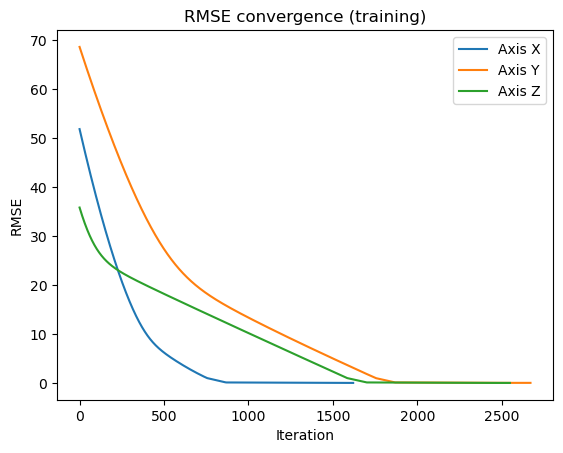

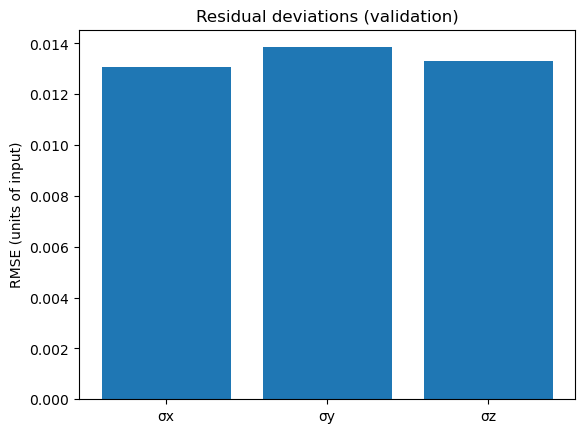

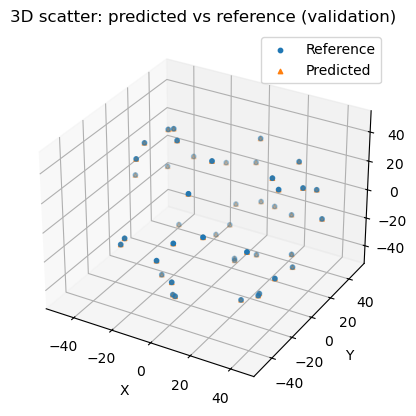

In [24]:

# 1) RMSE convergence (per axis)
plt.figure()
for k, hist in enumerate(rmse_histories):
    plt.plot(np.arange(len(hist)), hist, label=f"Axis {['X','Y','Z'][k]}")
plt.title("RMSE convergence (training)")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# 2) Residual deviations (bar chart) on validation if available, else training
plt.figure()
if len(Xv_local):
    vals = rmse_v
    plt.title("Residual deviations (validation)")
else:
    vals = rmse_tr
    plt.title("Residual deviations (training)")
plt.bar(["σx", "σy", "σz"], vals)
plt.ylabel("RMSE (units of input)")
plt.show()

# 3) 3D scatter (optional)
if PLOT_3D and len(Xv_local):
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Yv_fixed[:,0], Yv_fixed[:,1], Yv_fixed[:,2], marker='o', s=10, label='Reference')
    ax.scatter(Yv_pred[:,0],  Yv_pred[:,1],  Yv_pred[:,2],  marker='^', s=10, label='Predicted')
    ax.set_title("3D scatter: predicted vs reference (validation)")
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.legend()
    plt.show()


## 8. Export Results

In [28]:

results = {
    "mode": "GeoPOINT" if GEOPOINT_WORKBOOK else "External",
    "n_total": int(len(X_local)),
    "n_gcp": int(len(Xtr_local)),
    "n_valid": int(len(Xv_local)),
    "R": R.tolist(),
    "t": t.tolist(),
    "orthogonality": {
        "dots": dots,
        "norms": norms,
        "detR": detR,
    },
    "rmse": {
        "training": {"sx": float(rmse_tr[0]), "sy": float(rmse_tr[1]), "sz": float(rmse_tr[2])},
        "validation": {"sx": float(rmse_v[0]), "sy": float(rmse_v[1]), "sz": float(rmse_v[2])},
    },
}

import pandas as pd
df_out = pd.DataFrame({
    "R11":[R[0,0]],"R12":[R[0,1]],"R13":[R[0,2]],
    "R21":[R[1,0]],"R22":[R[1,1]],"R23":[R[1,2]],
    "R31":[R[2,0]],"R32":[R[2,1]],"R33":[R[2,2]],
    "tX":[t[0]],"tY":[t[1]],"tZ":[t[2]],
    "detR":[detR],
    "train_sx":[results["rmse"]["training"]["sx"]],
    "train_sy":[results["rmse"]["training"]["sy"]],
    "train_sz":[results["rmse"]["training"]["sz"]],
    "valid_sx":[results["rmse"]["validation"]["sx"]],
    "valid_sy":[results["rmse"]["validation"]["sy"]],
    "valid_sz":[results["rmse"]["validation"]["sz"]],
    "mode":[results["mode"]],
    "n_total":[results["n_total"]],"n_gcp":[results["n_gcp"]],"n_valid":[results["n_valid"]]
})
csv_path = "output_data/results_past.csv"
json_path = "output_data/results_past.json"
nb_path = "output_data/PAST.ipynb"

df_out.to_csv(csv_path, index=False)
with open(json_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Saved: {csv_path}\nSaved: {json_path}")


Saved: output_data/results_past.csv
Saved: output_data/results_past.json



## 9. Notes

- If **PyTorch** is not available, the notebook automatically switches to a **NumPy-only** gradient descent implementation with identical interface.
- The bias update is **scaled by 1000** to match the convergence behaviour observed in the original prototype.
- For **reproducibility**, set `RANDOM_SEED` and keep `N_GCP` fixed.


---

## Appendix 1. Linear Analogy of Learning

To illustrate the fundamental concept behind the PAST approach, this section presents a simple one-dimensional analogy of the learning process.  
A perceptron is trained to fit a noisy linear dataset generated with Gaussian noise.  
The resulting plot shows both the true linear function and the noisy data points, together with vertical ridgeline plots that visualize the residual distributions for different X positions.  

This example highlights the *white-box* nature of PAST — the same gradient-based learning principle applies, but in three dimensions for coordinate frame alignment.

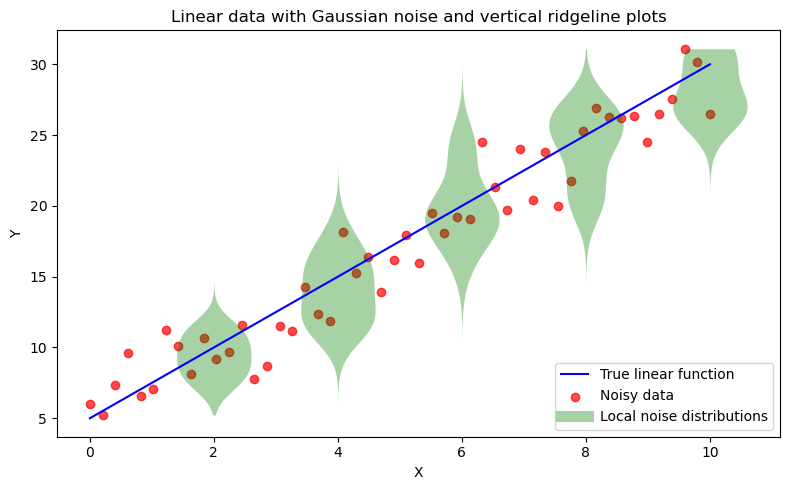

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# --- Generate synthetic linear data with Gaussian noise ---
np.random.seed(42)
x = np.linspace(0, 10, 50)
true_y = 2.5 * x + 5
noise = np.random.normal(0, 2, size=x.shape)
y_noisy = true_y + noise

# --- Plot true function and noisy data ---
plt.figure(figsize=(8,5))
line_true, = plt.plot(x, true_y, color='blue', label='True linear function')
scat_noisy = plt.scatter(x, y_noisy, color='red', alpha=0.7, label='Noisy data')

# --- Add vertical ridgeline (violin-like) plots ---
x_bins = np.arange(2, 11, 2)
for xb in x_bins:
    mask = (x >= xb - 1) & (x <= xb + 1)
    if mask.sum() > 3:
        kde = gaussian_kde(y_noisy[mask])
        y_vals = np.linspace(min(y_noisy), max(y_noisy), 200)
        density = kde(y_vals)
        density = density / density.max() * 0.6  # scale horizontally
        plt.fill_betweenx(y_vals, xb - density, xb + density,
                          color='green', alpha=0.35, linewidth=0)

# --- Add dummy patch for legend entry of violin plots ---
violin_patch = plt.Line2D([0], [0], color='green', lw=8, alpha=0.35)
plt.legend(
    handles=[line_true, scat_noisy, violin_patch],
    labels=['True linear function', 'Noisy data', 'Local noise distributions'],
    loc='lower right'
)

plt.title('Linear data with Gaussian noise and vertical ridgeline plots')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

**Figure. Linear analogy of the PAST learning process**

The plot illustrates how a perceptron learns a noisy linear relationship — a one-dimensional analogue of the transformation learning performed in PAST.  
The blue line represents the true underlying function, red dots show noisy measurements, and the green ridgeline plots depict the local Gaussian error distributions for different X positions.  
This visualization highlights how gradient-based optimization minimizes deviations toward the ideal model, similar to how PAST aligns 3D coordinate frames under noisy conditions.

---

## Appendix 2. PAST vs Least Squares Method (LSM) – Validation Comparison

This appendix compares the validation performance of the PAST and LSM models, using a bar chart to visualize the RMSE components.

[PAST]  Train RMSE: σx=2.961151e-03, σy=1.279923e-02, σz=4.084373e-04
[LSM ]  Train RMSE: σx=4.253347e-03, σy=1.320323e-02, σz=2.989629e-03
[PAST]  Valid RMSE: σx=1.307549e-02,  σy=1.384708e-02,  σz=1.328848e-02
[LSM ]  Valid RMSE: σx=1.711890e-02,  σy=1.256925e-02,  σz=1.216054e-02
Train ΔRMSE (PAST-LSM):  dx=-1.292e-03  dy=-4.040e-04  dz=-2.581e-03
Valid ΔRMSE (PAST-LSM):  dx=-4.043e-03  dy=1.278e-03  dz=1.128e-03


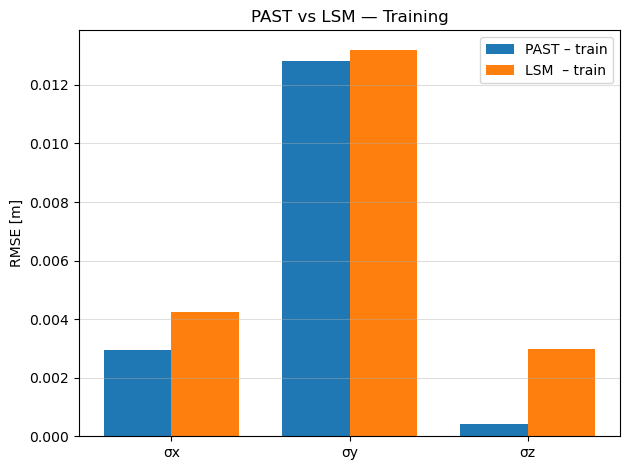

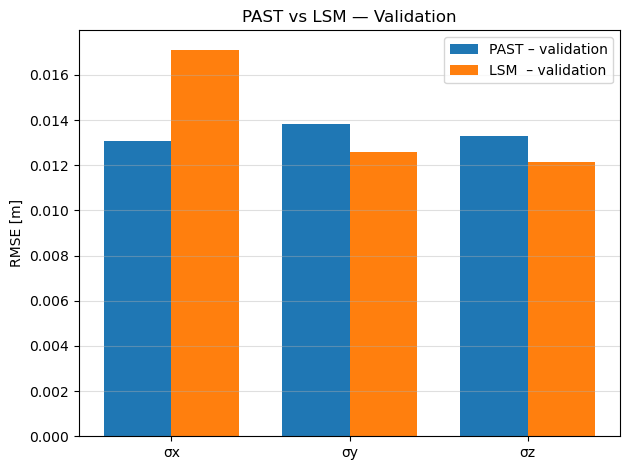

[PAST]  Train RMST: 0.01314
[LSM ]  Train RMST: 0.01419
Δ Train (PAST-LSM): -0.00105
[PAST]  Valid RMST: 0.02322
[LSM ]  Valid RMST: 0.02447
Δ Valid (PAST-LSM): -0.00125


In [ ]:
# --- Least Squares Method (LSM) via SVD (Kabsch, rigid: rotation + translation) ---
def lsm(X_src: np.ndarray, Y_dst: np.ndarray):
    """
    Solve: Y ≈ R @ X + t  (no scale)
    Returns R (3x3), t (3,)
    """
    Xc = X_src - X_src.mean(axis=0)
    Yc = Y_dst - Y_dst.mean(axis=0)
    H  = Xc.T @ Yc
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    # enforce det(R)=+1 (avoid reflection)
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
    t = Y_dst.mean(axis=0) - R @ X_src.mean(axis=0)
    return R, t

# --- Fit LSM on GCP (same split as PAST) ---
R_lsm, t_lsm = lsm(Xtr_local, Ytr_fixed)

# --- Predictions (train + optional validation) ---
Ytr_pred_lsm = (R_lsm @ Xtr_local.T + t_lsm.reshape(3,1)).T
if len(Xv_local):
    Yv_pred_lsm = (R_lsm @ Xv_local.T  + t_lsm.reshape(3,1)).T
else:
    Yv_pred_lsm = None  # explicit None when no validation

# --- Axis-wise RMSE (train / valid) ---
rmse_tr_lsm = np.array([rmse(Ytr_pred_lsm[:,i], Ytr_fixed[:,i]) for i in range(3)])
rmse_v_lsm  = (np.array([rmse(Yv_pred_lsm[:,i],  Yv_fixed[:,i])  for i in range(3)])
               if Yv_pred_lsm is not None else np.array([np.nan, np.nan, np.nan]))

print(f"[PAST]  Train RMSE: σx={rmse_tr[0]:.6e}, σy={rmse_tr[1]:.6e}, σz={rmse_tr[2]:.6e}")
print(f"[LSM ]  Train RMSE: σx={rmse_tr_lsm[0]:.6e}, σy={rmse_tr_lsm[1]:.6e}, σz={rmse_tr_lsm[2]:.6e}")
if Yv_pred_lsm is not None:
    print(f"[PAST]  Valid RMSE: σx={rmse_v[0]:.6e},  σy={rmse_v[1]:.6e},  σz={rmse_v[2]:.6e}")
    print(f"[LSM ]  Valid RMSE: σx={rmse_v_lsm[0]:.6e},  σy={rmse_v_lsm[1]:.6e},  σz={rmse_v_lsm[2]:.6e}")

# --- Differences (PAST - LSM); negative → PAST lepszy (mniejszy błąd) ---
def _diff_line(name, a, b):
    d = a - b
    print(f"{name} ΔRMSE (PAST-LSM):  dx={d[0]:.3e}  dy={d[1]:.3e}  dz={d[2]:.3e}")

_diff_line("Train", rmse_tr, rmse_tr_lsm)
if Yv_pred_lsm is not None:
    _diff_line("Valid", rmse_v, rmse_v_lsm)

# --- Bar charts: Training (always) + Validation (if present) ---
labels = ["σx","σy","σz"]
x = np.arange(3); w = 0.38

# common Y scale for comparison readability
ymax_train = 1.05 * np.nanmax(np.r_[rmse_tr, rmse_tr_lsm])

plt.figure()
plt.bar(x - w/2, rmse_tr,     w, label="PAST – train")
plt.bar(x + w/2, rmse_tr_lsm, w, label="LSM  – train")
plt.xticks(x, labels)
plt.ylim(0, ymax_train if np.isfinite(ymax_train) else None)
plt.ylabel("RMSE [m]")
plt.title("PAST vs LSM — Training")
plt.grid(axis='y', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

if Yv_pred_lsm is not None:
    ymax_valid = 1.05 * np.nanmax(np.r_[rmse_v, rmse_v_lsm])
    plt.figure()
    plt.bar(x - w/2, rmse_v,     w, label="PAST – validation")
    plt.bar(x + w/2, rmse_v_lsm, w, label="LSM  – validation")
    plt.xticks(x, labels)
    plt.ylim(0, ymax_valid if np.isfinite(ymax_valid) else None)
    plt.ylabel("RMSE [m]")
    plt.title("PAST vs LSM — Validation")
    plt.grid(axis='y', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

def rmst(vec3):
    vec3 = np.asarray(vec3, dtype=float)
    return float(np.sqrt(np.sum(vec3**2)))

rmst_tr_past = rmst(rmse_tr)
rmst_tr_lsm  = rmst(rmse_tr_lsm)
rmst_v_past  = rmst(rmse_v)      if np.all(np.isfinite(rmse_v))      else np.nan
rmst_v_lsm   = rmst(rmse_v_lsm)  if np.all(np.isfinite(rmse_v_lsm))  else np.nan

print(f"[PAST]  Train RMST: {rmst_tr_past:.5f}")
print(f"[LSM ]  Train RMST: {rmst_tr_lsm:.5f}")
print(f"Δ Train (PAST-LSM): {rmst_tr_past - rmst_tr_lsm:.5f}")

if np.isfinite(rmst_v_past) and np.isfinite(rmst_v_lsm):
    print(f"[PAST]  Valid RMST: {rmst_v_past:.5f}")
    print(f"[LSM ]  Valid RMST: {rmst_v_lsm:.5f}")
    print(f"Δ Valid (PAST-LSM): {rmst_v_past - rmst_v_lsm:.5f}")
